### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# carregar o .env com as credenciais
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")


# detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"


# parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.purchasing-purchaseorderheader"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"


# configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


#doc: tables_to_process: lista de tabelas que serão processadas
#     output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned

In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.purchasing-purchaseorderheader']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productcosthistory
production-productinventory
production-productsubcategory
purchasing-purchaseorderdetail
purchasing-purchaseorderheader
purchasing-vendor
sales-creditcard
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesperson
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Setup inicial do df para realizar a EDA 

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")


print("Todas as tabelas foram processadas com sucesso!")

Processando tabela: desafioadventureworks-446600.raw_data.purchasing-purchaseorderheader
Lendo os dados do BigQuery...
Tabela purchasing_purchaseorderheader processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: purchasing_purchaseorderheader


In [7]:
# Atribuir o df a uma variável com nome mais simples
purchasing_purchaseorderheader = df_processados['purchasing_purchaseorderheader']

print(f"Colunas: {purchasing_purchaseorderheader.shape[1]}\nLinhas: {purchasing_purchaseorderheader.shape[0]}")

Colunas: 12
Linhas: 4012


In [8]:
purchasing_purchaseorderheader.head()

,purchaseorderid,revisionnumber,status,employeeid,vendorid,shipmethodid,orderdate,shipdate,subtotal,taxamt,freight,modifieddate
0,4005,6,2,252,1636,3,2014-01-27 00:00:00+00:00,2014-02-21 00:00:00+00:00,7425.00,594.00,148.50,2015-08-12 12:25:46.373000+00:00
1,4010,7,2,260,1574,3,2013-11-09 00:00:00+00:00,2013-12-04 00:00:00+00:00,37760.00,3020.80,755.20,2015-08-12 12:25:46.470000+00:00
2,4002,7,2,252,1574,3,2014-09-22 00:00:00+00:00,2014-10-17 00:00:00+00:00,1020.00,81.60,20.40,2015-08-12 12:25:46.343000+00:00
3,4007,14,2,251,1594,3,2014-03-01 00:00:00+00:00,2014-03-26 00:00:00+00:00,554020.00,44321.60,11080.40,2015-08-12 12:25:46.407000+00:00
4,4012,9,2,254,1636,3,2014-06-24 00:00:00+00:00,2014-07-19 00:00:00+00:00,997680.00,79814.40,19953.60,2015-08-12 12:25:46.483000+00:00


In [9]:
# Identificar duplicadas
duplicadas = purchasing_purchaseorderheader[purchasing_purchaseorderheader.duplicated(subset=['purchaseorderid'], keep=False)]

# Verificar se existem duplicadas
if not duplicadas.empty:
    
    duplicadas_ordenadas = duplicadas.sort_values(by=['purchaseorderid', 'modifieddate'])

    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

Não foram encontradas duplicadas.


In [10]:
# Remover duplicadas* 
purchasing_purchaseorderheader = purchasing_purchaseorderheader.drop_duplicates(subset=['purchaseorderid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(purchasing_purchaseorderheader)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = purchasing_purchaseorderheader.copy()


#doc: bkp = backup (cópia)
#doc*: mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
#      Importante, pois se houver erro na ingestão (duplicação), mantém os dados íntegros.

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 4012


In [11]:
# Ordenar e exibir o df por 'purchaseorderid'
purchasing_purchaseorderheader = purchasing_purchaseorderheader.sort_values(by=['purchaseorderid'])

print(purchasing_purchaseorderheader)

      purchaseorderid  revisionnumber  status  employeeid  vendorid  shipmethodid                 orderdate                  shipdate  subtotal   taxamt  freight                     modifieddate
871                 1               4       4         258      1580             3 2011-04-16 00:00:00+00:00 2011-04-25 00:00:00+00:00    201.04    16.08     5.03        2011-04-25 00:00:00+00:00
3385                2               4       1         254      1496             5 2011-04-16 00:00:00+00:00 2011-04-25 00:00:00+00:00    272.10    21.77     6.80        2011-04-25 00:00:00+00:00
3302                3               4       4         257      1494             2 2011-04-16 00:00:00+00:00 2011-04-25 00:00:00+00:00   8847.30   707.78   221.18        2011-04-25 00:00:00+00:00
2188                4               4       3         261      1650             5 2011-04-16 00:00:00+00:00 2011-04-25 00:00:00+00:00    171.08    13.69     4.28        2011-04-25 00:00:00+00:00
2289                5    

In [12]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in purchasing_purchaseorderheader.columns:   
    missing_rows = purchasing_purchaseorderheader[purchasing_purchaseorderheader[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'purchaseorderid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'purchaseorderid'.

Coluna 'revisionnumber': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'revisionnumber'.

Coluna 'status': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'status'.

Coluna 'employeeid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'employeeid'.

Coluna 'vendorid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'vendorid'.

Coluna 'shipmethodid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'shipmethodid'.

Coluna 'orderdate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'orderdate'.

Coluna 'shipdate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'shipdate'.

Coluna 'subtotal': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'subtotal'.

Coluna 'taxamt': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'taxamt'.

Coluna 'freight': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'fr

In [13]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = purchasing_purchaseorderheader.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

Valores únicos incluindo NaN:
purchaseorderid    4012
revisionnumber       10
status                4
employeeid           12
vendorid             86
shipmethodid          5
orderdate           300
shipdate            297
subtotal            351
taxamt              351
freight             351
modifieddate        306
dtype: int64


In [14]:
#verificar informações do df
purchasing_purchaseorderheader.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4012 entries, 871 to 4
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   purchaseorderid  4012 non-null   Int64              
 1   revisionnumber   4012 non-null   Int64              
 2   status           4012 non-null   Int64              
 3   employeeid       4012 non-null   Int64              
 4   vendorid         4012 non-null   Int64              
 5   shipmethodid     4012 non-null   Int64              
 6   orderdate        4012 non-null   datetime64[us, UTC]
 7   shipdate         4012 non-null   datetime64[us, UTC]
 8   subtotal         4012 non-null   float64            
 9   taxamt           4012 non-null   float64            
 10  freight          4012 non-null   float64            
 11  modifieddate     4012 non-null   datetime64[us, UTC]
dtypes: Int64(6), datetime64[us, UTC](3), float64(3)
memory usage: 431.0 KB


In [15]:
#avaliando as variáveis qualitativas*

coluna_quantitativa = ["status"]
for col in coluna_quantitativa:
    counts = purchasing_purchaseorderheader[col].value_counts().nlargest(10)
    percentages = (counts / purchasing_purchaseorderheader.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    print(summary)    


#doc*: variáveis qualitativas são um tipo de variável estatística que representam características ou atributos dos dados, sem serem medidas numericamente
#      no nosso caso, status, por exemplo

#doc: status. 1 = Pending; 2 = Approved; 3 = Rejected; 4 = Complete

        qtde.       %
status               
4        3689  91.95%
1         225   5.61%
3          86   2.14%
2          12   0.30%


C:\Users\wrpen\AppData\Local\Temp\ipykernel_56348\4283749172.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


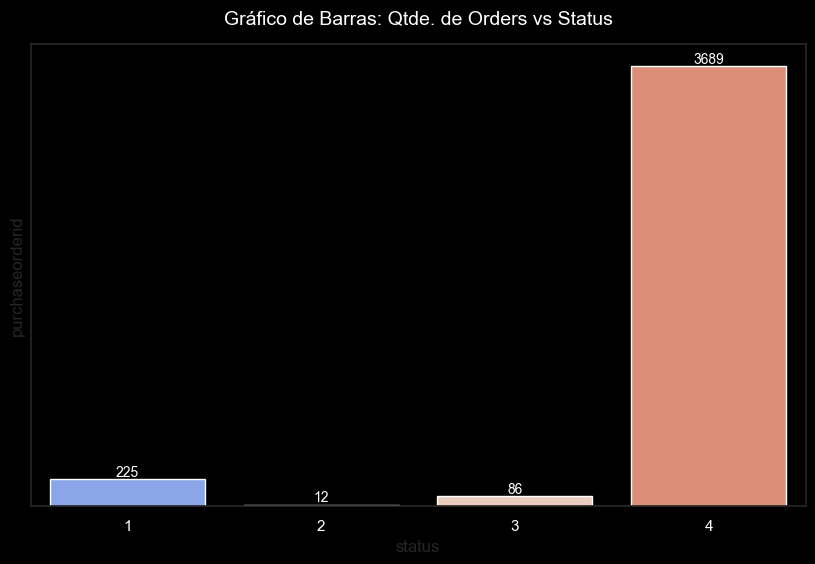

In [16]:
# Configurar o gráfico
sns.set(style='white', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

# purchaseorderid por status
status_counts = purchasing_purchaseorderheader.groupby('status')['purchaseorderid'].count().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='status', 
    y='purchaseorderid', 
    data=status_counts, 
    palette='coolwarm'
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', color='white', fontsize=10)

plt.title('Gráfico de Barras: Qtde. de Orders vs Status', fontsize=14, color='white', pad=15)
ax.tick_params(axis='y', left=False, labelleft=False)
ax.tick_params(axis='x', colors='white')
ax.grid(False)
plt.show()

In [17]:
purchasing_purchaseorderheader.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4012 entries, 871 to 4
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   purchaseorderid  4012 non-null   Int64              
 1   revisionnumber   4012 non-null   Int64              
 2   status           4012 non-null   Int64              
 3   employeeid       4012 non-null   Int64              
 4   vendorid         4012 non-null   Int64              
 5   shipmethodid     4012 non-null   Int64              
 6   orderdate        4012 non-null   datetime64[us, UTC]
 7   shipdate         4012 non-null   datetime64[us, UTC]
 8   subtotal         4012 non-null   float64            
 9   taxamt           4012 non-null   float64            
 10  freight          4012 non-null   float64            
 11  modifieddate     4012 non-null   datetime64[us, UTC]
dtypes: Int64(6), datetime64[us, UTC](3), float64(3)
memory usage: 431.0 KB


In [18]:
# Variáveis quantitativas*: estatísticas descritivas para verificar se ainda há o que ser feito antes de exportar os dados ao BigQuery

# Identificar colunas numéricas para análise de outliers
numeric_columns = ['subtotal', 'taxamt', 'freight']

# Estatísticas Descritivas das colunas numéricas*
print(purchasing_purchaseorderheader[numeric_columns].describe())

# Cálculo de limites para outliers (IQR)**
for col in numeric_columns:
    q1 = purchasing_purchaseorderheader[col].quantile(0.25)
    q3 = purchasing_purchaseorderheader[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Exibir os limites
    print(f"\nColuna: {col}")
    print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")
    
    # Detecção e Análise de Outliers***
    outliers = purchasing_purchaseorderheader[(purchasing_purchaseorderheader[col] < lower_bound) | (purchasing_purchaseorderheader[col] > upper_bound)]
    print(f"Outliers detectados ({len(outliers)}):")
    print(outliers[[col]])


#doc*: variáveis quantitativas são um tipo de dado que pode ser representado por números e medidas objetivas
#doc*: realizar estatísticas descritivas para entender a centralidade e variação dos dados (valores médios, mínimos, máximos, etc.)
#doc**: calcular limites para identificar outliers (valores extremos que podem indicar erros ou casos excepcionais nos dados)
#doc***: verificar a existência de outliers para decidir ações como remoção, substituição ou tratamento, garantindo qualidade dos dados
#doc****: as colunas analisadas apresentam outliers: 


# Conclusões e justificativas sobre os outliers nas colunas analisadas:
#
# **1. Coluna: subtotal**
# - Limite inferior: -41,324.85, Limite superior: 69,913.83.
# - Outliers detectados: 89.
# - Conclusão: Os valores fora do limite representam transações de alto valor, que 
#   podem ser compras de grandes volumes ou produtos premium. No setor de compras, 
#   esses valores são esperados em negociações corporativas ou em pedidos excepcionais.
# - Justificativa para manter: Esses valores refletem comportamentos reais do negócio
#   e podem ser relevantes para identificar grandes clientes ou eventos atípicos.
#
# **2. Coluna: taxamt**
# - Limite inferior: -3,305.99, Limite superior: 5,593.11.
# - Outliers detectados: 89.
# - Conclusão: Valores elevados de impostos estão relacionados a pedidos com altos 
#   subtotais. Isso é consistente com a política fiscal progressiva, onde valores 
#   maiores geram taxas proporcionalmente maiores.
# - Justificativa para manter: Esses valores indicam pedidos de alto valor, que são 
#   comuns em transações grandes e podem ser úteis para análises financeiras ou fiscais.
#
# **3. Coluna: freight**
# - Limite inferior: -1,033.12, Limite superior: 1,747.85.
# - Outliers detectados: 89.
# - Conclusão: Custos de frete elevados estão associados a entregas de grandes volumes 
#   ou para regiões de difícil acesso, onde o transporte é mais caro.
# - Justificativa para manter: Esses valores são reais dentro do contexto de logística,
#   indicando regiões ou clientes com maior complexidade de entrega.
#
# **Conclusão Geral:**
# - Os outliers identificados são consistentes com o contexto de compras e logística,
#   principalmente considerando que o banco de dados representa transações de 
#   diferentes magnitudes e tipos.
# - Manter os outliers permite que análises futuras identifiquem clientes estratégicos,
#   padrões de compra atípicos e regiões com custos de transporte diferenciados.
# - A remoção poderia distorcer as análises e mascarar comportamentos legítimos do negócio.
#
# **Conclusão:**
# - Manter os outliers nos dados exportados para o BigQuery.
# - Implementar um sistema de flagging para marcar os outliers e monitorar sua influência
#   em análises específicas (ex.: média, desvios padrão).


       subtotal   taxamt  freight
count   4012.00  4012.00  4012.00
mean   15900.30  1272.02   394.81
std    28142.44  2251.40   644.05
min       37.08     2.97     0.93
25%      389.65    31.17     9.74
50%     2934.54   234.76    73.36
75%    28199.33  2255.95   704.98
max   997680.00 79814.40 19953.60

Coluna: subtotal
Limite inferior: -41324.850000000006, Limite superior: 69913.83
Outliers detectados (89):
      subtotal
3149  79204.12
721   91117.95
3158  73377.15
722   91117.95
3189 101720.85
...        ...
3153  79204.12
770   91117.95
3    554020.00
9    396729.00
4    997680.00

[89 rows x 1 columns]

Coluna: taxamt
Limite inferior: -3305.988, Limite superior: 5593.1064
Outliers detectados (89):
       taxamt
3149  6336.33
721   7289.44
3158  5870.17
722   7289.44
3189  8137.67
...       ...
3153  6336.33
770   7289.44
3    44321.60
9    31738.32
4    79814.40

[89 rows x 1 columns]

Coluna: freight
Limite inferior: -1033.12115, Limite superior: 1747.8456500000002
Outliers det

C:\Users\wrpen\AppData\Local\Temp\ipykernel_56348\1037129091.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  purchasing_purchaseorderheader['order_month'] = purchasing_purchaseorderheader['orderdate'].dt.to_period('M')


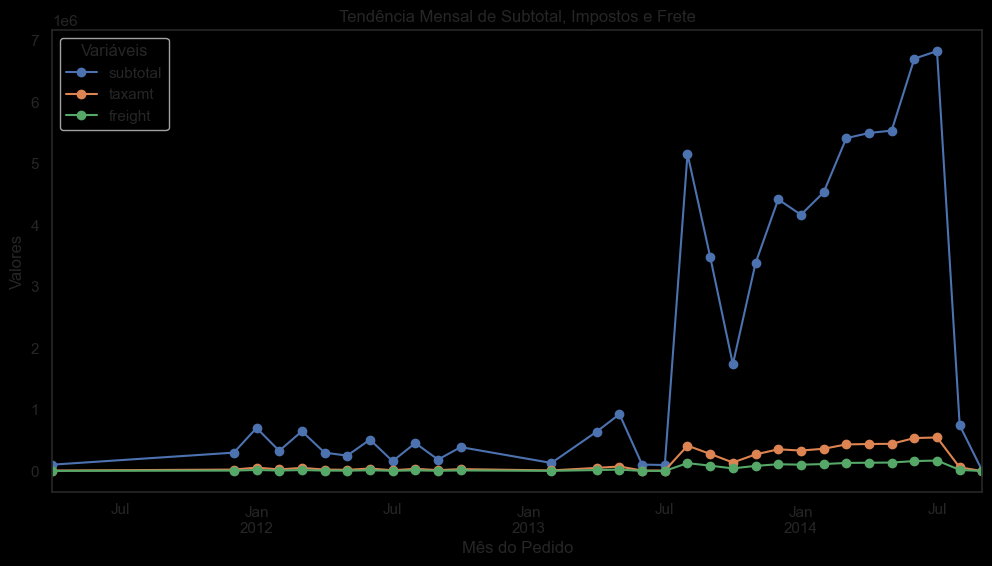

In [19]:
# Converter orderdate para ano e mês
purchasing_purchaseorderheader['order_month'] = purchasing_purchaseorderheader['orderdate'].dt.to_period('M')

# Somar subtotal, taxamt e freight por mês
monthly_summary = purchasing_purchaseorderheader.groupby('order_month')[['subtotal', 'taxamt', 'freight']].sum()

monthly_summary.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Tendência Mensal de Subtotal, Impostos e Frete')
plt.xlabel('Mês do Pedido')
plt.ylabel('Valores')
plt.grid(False)
plt.legend(title='Variáveis')
plt.show()


In [20]:
purchasing_purchaseorderheader = purchasing_purchaseorderheader.drop(columns=["order_month"])


In [21]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['purchasing_purchaseorderheader'] = purchasing_purchaseorderheader

In [22]:
# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
 
    output_table = f"{output_dataset}.{table_name}"
   
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela purchasing_purchaseorderheader exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.purchasing_purchaseorderheader.
